In [1]:
import sys, os
from importlib import reload
import json, csv

import math , pywt , numpy as np, pandas as pd
import scipy.stats as stats, scipy.signal as signal

from IPython.display import display, HTML
from matplotlib import pyplot as plt


from utils import *
import constants
reload(constants)
from constants import *

--> Importing bpmn_utils module file.

--> Importing grouped_mean module file.

--> Importing lhipa_utils module file.



## Config & functions

In [2]:
### Config 

EYE_IMOTIONSFEATURES_AND_AOIS_FILE = DATA_DIR + r'\eventsDataWithAois.csv' 
PERCEIVED_DIFFICULTY_DATA = DATA_DIR + r'\perceivedDifficulty.csv'
EYEMIND_FULL_DATA = DATA_DIR + r'\allDataEyeMind.csv'
PUPIL_FILTERED_FILE = DATA_DIR + r'\PupilData_filtered.csv'
ANSWERS_DATA = DATA_DIR + r'\answers.csv'

QUESTION_FILE_PARSED = ORIG_DIR + r'\QuestionSetParsed.csv'
QUESTION_DETAILS = ORIG_DIR + r'\QuestionDetails.csv'

DEMOGRAPHIC_DATA = DATA_DIR + r'\surveys.csv'
DEMOGRAPHIC_CATALOG_DATA = DATA_DIR + r'\surveys_catalog.json'
DEMOGRAPHIC_RCATALOG_DATA = DATA_DIR + r'\surveys_rcatalog.json'

IMG_DIR = DATA_DIR + 'img'
if not os.path.exists(IMG_DIR): os.mkdir(IMG_DIR)


In [3]:
def get_subparts(d, qElements):
    # Apply LHIPA BEFORE and AFTER the latest timestamp of the question elements
    # 1. Find first fix on the question elements
    #qElements = (tDetails['element1'].iloc[0], tDetails['element2'].iloc[0])
    d['qElement'] = 0
    d.loc[d['element']==qElements[0], ['qElement']] = 1
    d.loc[d['element']==qElements[1], ['qElement']] = 2
    d_qElements_firstFix = []
    try: d_qElements_firstFix.append(d[d.qElement == 1].iloc[0])
    except IndexError: d_qElements_firstFix.append(d.iloc[0])
    try: d_qElements_firstFix.append(d[d.qElement == 2].iloc[0])
    except IndexError: d_qElements_firstFix.append(d.iloc[0])
    
    # 2. Retrieve the associated timestamp (relative to the begining of this task)
    qElements_ts = [
        d_qElements_firstFix[0]['Timestamp'], 
        d_qElements_firstFix[1]['Timestamp']
    ]
    ts_end_search = max(qElements_ts)

    # 3. Create subparts
    d['Phase'] = 0
    # search part
    d_search = (d.loc[d['Timestamp'] <=  ts_end_search].copy(deep=True)).reset_index()
    d.loc[d['Timestamp'] <=  ts_end_search, ['Phase']] = 1
    # solve part
    d_solve = (d.loc[d['Timestamp'] >  ts_end_search].copy(deep=True)).reset_index()
    d.loc[d['Timestamp'] >  ts_end_search, ['Phase']] = 2

    return {'search':{'d':d_search}, 'solve':{'d':d_solve}}
# DEF: get_subparts


In [4]:
def plotFixDuration(ax, t, s, params):
    ax.plot(t/1000, s)

    ax.axhline(150, linewidth=0.3, color=(0.7, 0.7, 0.7, 0.5))
    ax.axhline(250, linewidth=0.3, color=(1.0, 0.7, 0.7, 0.5))
    ax.axhline(500, linewidth=0.3, color=(1.0, 0.0, 0.0, 0.5))
    
    ax.set_yticks([150, 250, 500, 1000], [150, 250, 500, 1000])

    if 'cnt' in params.keys():
        cnt = params['cnt']
        ax2 = ax.twinx()
        if '250' in cnt.keys(): ax2.plot(t/1000, cnt['250'], 'tab:green', alpha=0.5)
        if '500' in cnt.keys(): ax2.plot(t/1000, cnt['500'], 'tab:orange', alpha=0.5)
        if 'mm500' in cnt.keys():
            for pos in range(len(t)):
                localMax = cnt['mm500'][pos]
                if localMax > 0:
                    ax.axvline(t[pos]/1000, linewidth=0.3, color=(0, 0, 0, 0.5))

    if 'title' in params.keys():
        ax.set_title(params['title'])
    if 'xlabel' in params.keys():
        ax.set_xlabel(params['xlabel'])
    if 'ylabel' in params.keys():
        ax.set_ylabel(params['ylabel'])
        # change the color if a second axis is displayed
        if 'cnt' in params.keys():
            ax.set_ylabel(params['ylabel'], color='tab:blue')
    if 'ylabel2' in params.keys():
        ax2.set_ylabel(params['ylabel2'])

    ax.set_xlim(0)
    if 'xlim' in params.keys():
        ax.set_xlim(params['xlim'])



In [5]:
def scatFixDuration(ax, df, params):
    col_dt = 'dt'
    if 'col_dt' in params.keys(): col_dt = params['col_dt']
    col = 'Fixation Duration'
    if 'col' in params.keys(): col = params['col']

    # Clipping at 750ms
    df[col+'_clipped'] = df[col].values
    df.loc[df[col].values > 750, col+'_clipped'] = 750

    # Colors & style
    bColor = params['bColor'] if 'bColor' in params else False
    if bColor:
        c = {'150': 'tab:gray', '250': 'tab:green', '500': 'tab:orange', '750': 'tab:purple'}
        a = {'150': .05, '250': .15, '500': .75, '750': .85}
    else:
        c = {'150': 'tab:gray', '250': 'tab:gray', '500': 'k', '750': 'k'}
        a = {'150': .05, '250': .15, '500': .75, '750': .85}
    
    ax.axhline(150, linewidth=0.3, color=c['150'], alpha=0.5)
    ax.axhline(250, linewidth=0.3, color=c['250'], alpha=0.5)
    ax.axhline(500, linewidth=0.3, color=c['500'], alpha=0.5)

    df.loc[:, 'fixColor'] = 'tab:gray'
    df.loc[df[col].values > 150, 'fixColor'] = c['150']
    df.loc[df[col].values > 250, 'fixColor'] = c['250']
    df.loc[df[col].values > 500, 'fixColor'] = c['500']
    df.loc[df[col].values > 750, 'fixColor'] = c['750']
    df.loc[:, 'fixAlpha'] = a['150']
    df.loc[df[col].values > 150, 'fixAlpha'] = a['250']
    df.loc[df[col].values > 250, 'fixAlpha'] = a['500']
    df.loc[df[col].values > 500, 'fixAlpha'] = a['750']

    x_axis = list(df[col_dt].values/1000)
    y_axis = list(df[col+'_clipped'].values)
    ax.scatter(x_axis, y_axis,
               c=list(df.loc[:, 'fixColor']), alpha=list(df.loc[:, 'fixAlpha']))

    ax.set_yticks([150, 250, 500, 1000], [150, 250, 500, 1000])

    if 'title' in params.keys():
        ax.set_title(params['title'])
    if 'xlabel' in params.keys():
        ax.set_xlabel(params['xlabel'])
    if 'ylabel' in params.keys():
        ax.set_ylabel(params['ylabel'])

    ax.set_xlim(0)
    if 'xlim' in params.keys():
        ax.set_xlim(params['xlim'])

    ax.set_ylim(0, 800)


In [6]:
def my_wilcoxon(s1, s2):
    stat, p = stats.wilcoxon(s1, s2)
    return {'stat': stat, 'p': p, 'm1': np.mean(s1), 'm2': np.mean(s2)}


## Load Data
Based on the tests in the Data suitability notebook. The data are prepared (read, cleaned, etc.) and some additional informations coming from the different surveys.

In [7]:
### Load DataFrames - Pickling
if os.path.isdir(DATA_DIR + 'pkl'):
    eifaData = pd.read_pickle(DATA_DIR + 'pkl' + r'\eifaData.pkl')
    perceivedDifficultyData = pd.read_pickle(DATA_DIR + 'pkl' + r'\perceivedDifficultyData.pkl')
    answersData = pd.read_pickle(DATA_DIR + 'pkl' + r'\answersData.pkl')
    questionsFileParsed = pd.read_pickle(DATA_DIR + 'pkl' + r'\questionsFileParsed.pkl')
    eyeMindFullData = pd.read_pickle(DATA_DIR + 'pkl' + r'\eyeMindFullData.pkl')
    pupiFiltered = pd.read_pickle(DATA_DIR + 'pkl' + r'\pupiFiltered.pkl')

    demogData = pd.read_pickle(DATA_DIR + 'pkl' + r'\demogData.pkl')
    eifaData2 = pd.read_pickle(DATA_DIR + 'pkl' + r'\eifaData2.pkl')
    pupiFiltered2 = pd.read_pickle(DATA_DIR + 'pkl' + r'\pupiFiltered2.pkl')
    perceivedDifficultyData2 = pd.read_pickle(DATA_DIR + 'pkl' + r'\perceivedDifficultyData2.pkl')
    answersData2 = pd.read_pickle(DATA_DIR + 'pkl' + r'\answersData2.pkl')
   

## DEMO

Select a participant and one task par type (essential / accidental) & level (simple-low / complex-high) of complexity

In [8]:
### Set the list of recorded participants and tasks
participantIDs = list(eifaData['participant'].unique())
taskIDs = questionsFileParsed.loc[questionsFileParsed['Type2']=='MainQuestion']['id'].values.tolist()
taskIDs.remove(1)

display(participantIDs)
display(taskIDs)


['P12',
 'P14',
 'P16',
 'P17',
 'P18',
 'P21',
 'P22',
 'P23',
 'P24',
 'P26',
 'P27',
 'P28',
 'P29',
 'P30',
 'P31',
 'P32',
 'P33',
 'P35',
 'P36',
 'P01',
 'P11',
 'P13',
 'P15',
 'P25',
 'P34']

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [9]:
### Load/Prepare demographic data
#
# Load demographic data (and catalogs)
# demogData = pd.read_csv(DEMOGRAPHIC_DATA)
with open(DEMOGRAPHIC_CATALOG_DATA) as f:
    demogCatalog = json.load(f)
    f.close()

with open(DEMOGRAPHIC_RCATALOG_DATA) as f:
    demogRCatalog = json.load(f)
    f.close()
demogData_cols = ['ParticipantID', 'Familiarized', 'StrategyFirst', 'StrategyChanged']

famParticipants = demogData.loc[demogData['Familiarized']==1 & demogData['ParticipantID'].isin(participantIDs)]
print(f"Participant familiarized with BPMN:\t{famParticipants.index.size}")

print(f"Strategy 1: {demogRCatalog['StrategyFirst']['1']}")
PARTICIPANT_READING_STRATEGY1 = (demogData.loc[
    (demogData['StrategyFirst'] == 1) & (demogData['StrategyChanged'] == 1), #
    ['ParticipantID']
])
print(f"Participant using strategy 1 only:\t{PARTICIPANT_READING_STRATEGY1.index.size}")
display(PARTICIPANT_READING_STRATEGY1)


# eifaData2 = eifaData.merge(demogData, left_on='participant', right_on='ParticipantID', how='left')
# pupiFiltered2 = pupiFiltered.merge(demogData, left_on='participant', right_on='ParticipantID', how='left')
# perceivedDifficultyData2 = perceivedDifficultyData.merge(demogData, left_on='participant', right_on='ParticipantID', how='left')
# answersData2 = answersData.merge(demogData, left_on='participant', right_on='ParticipantID', how='left')

# pupiFiltered2.head()

Participant familiarized with BPMN:	15
Strategy 1: other
Participant using strategy 1 only:	1


ParticipantID
2           P12

In [10]:
### DEMO: Select a participant and one task per type of complexity.
# This will produce 3 different results (tData_ess, tData_acc, tData_simple)
sample_pID = 'P22' #P26' # in PARTICIPANT_READING_STRATEGY1
sample_tID = {'Simple': 7, 'Ess': 5, 'Acc': 19}


get_ts = lambda x: (x['Timestamp'] - x['Timestamp'].iloc[0])/1000

display(PARTICIPANT_READING_STRATEGY1)

ParticipantID
2           P12

In [11]:
### DEMO: Create tData - Extract data for a given user 

pupiFiltered_l = pupiFiltered2[(pupiFiltered2['Type2'] == 'MainQuestion') & (~pupiFiltered2['tabName'].isna())].copy(deep=True)

fixationData = eifaData2.loc[(~eifaData2['FixID'].isna()) & (~eifaData2['currentQuestion'].isna())].copy(deep=True)

def set_dt(df, tsCol = 'Timestamp', dtCol = 'dt'):
    dt = df[tsCol] - df[tsCol].iloc[0]
    df[dtCol] = dt

# Read QUESTION_FILE_PARSED
question_details = pd.read_csv(QUESTION_DETAILS)


#---------------------------------------------------



# pupData
pupData = pupiFiltered_l[
    pupiFiltered_l['currentQuestion'].isin(sample_tID.values()) & 
    (pupiFiltered_l['participant']==sample_pID)
].copy(deep=True)
pupData_simple = pupData.loc[(pupData['currentQuestion'] == sample_tID['Simple']) & (pupData['Type3'] == 'essentialComlexity')].copy(deep=True)
set_dt(pupData_simple)
pupData_ess = pupData.loc[pupData['currentQuestion'] == sample_tID['Ess']].copy(deep=True)
set_dt(pupData_ess)
pupData_acc = pupData.loc[pupData['currentQuestion'] == sample_tID['Acc']].copy(deep=True)
set_dt(pupData_acc)


# fixData
fixData = fixationData[
    fixationData['currentQuestion'].isin(sample_tID.values()) & 
    (fixationData['participant']==sample_pID)
].copy(deep=True)
fixData_simple = fixData.loc[(fixData['currentQuestion'] == sample_tID['Simple']) & (fixData['Type3'] == 'essentialComlexity')].copy(deep=True)
set_dt(fixData_simple)
fixData_ess = fixData.loc[fixData['currentQuestion'] == sample_tID['Ess']].copy(deep=True)
set_dt(fixData_ess)
fixData_acc = fixData.loc[fixData['currentQuestion'] == sample_tID['Acc']].copy(deep=True)
set_dt(fixData_acc)


# qData
qData_simple = question_details[question_details['id'] == sample_tID['Simple']]
qData_ess = question_details[question_details['id'] == sample_tID['Ess']]
qData_acc = question_details[question_details['id'] == sample_tID['Acc']]

def adaptToSlidingWindow(df, measure,
    wTime = 10 , wPace = 'retrograde'):

    dfCopy = df.copy(deep=True)

    dfX  = np.array(dfCopy[measure])
    dfT = np.array(dfCopy['dt'])
    # l = len(dfT)

    # freq = 1000*l/(dfT[-1] - dfT[0])
    # w = math.floor(freq * wTime)

    if wPace == 'progressive':
        w = (dfT - dfT[-1] + wTime*1000) > 0
        w[-1] = False
        dfXe = np.concatenate((dfX, np.flip(dfX[w])))
        # dfXe = np.concatenate((dfX, dfX[-1 - (w-1):0]))
        lw = len(dfX[w])
        dfTe = np.concatenate((dfT, dfT[-1] + np.flip(dfT[-1] - dfT[w])))
        # iDt = dfT[-1] - dfT[-2]
        # dfTe = np.concatenate((dfT, dfT[-1]+np.array(1+range(lw))*iDt))
        lw = -lw
    else: # wPace == 'retrograde'
        w = (dfT - dfT[0] - wTime*1000) < 0
        w[0] = False
        dfXe = np.concatenate((np.flip(dfX[w]), dfX))
        # dfXe = np.concatenate((dfX[w-1:0:-1], dfX))
        lw = len(dfX[w])
        dfTe = np.concatenate((dfT[0] - np.flip(dfT[w]), dfT))
        # iDt = dfT[1] - dfT[0]
        # dfTe = np.concatenate((dfT[0]-np.array(range(lw,0,-1))*iDt, dfT))

    return dfXe, dfTe, lw


print('pupData_simple')
display(pupData_simple.head(5))
print('fixData_simple')
display(fixData_simple.head(5))

pupData_simple


Unnamed: 0.1  index  Unnamed: 0_x  eventSource    Timestamp  \
372542        462030  53856       1768324  eye-tracker  5463414.767   
372543        462031  53857       1768327  eye-tracker  5463439.764   
372544        462032  53858       1768330  eye-tracker  5463464.747   
372545        462033  53859       1768333  eye-tracker  5463489.745   
372546        462034  53860       1768336  eye-tracker  5463514.773   

        validLeft  validRight  leftPupilValidity  rightPupilValidity  \
372542          1           1                  1                   1   
372543          1           1                  1                   1   
372544          1           1                  1                   1   
372545          1           1                  1                   1   
372546          1           1                  1                   1   

        snapshotId  ...  StrategySecond StrategySecondOther  Familiarized  \
372542         225  ...            -1.0                -1.0           0.0   
372543         226  ...            -1.0                -1.0           0.0   
372544         226  ...            -1.0                -1.0           0.0   
372545         226  ...            -1.0                -1.0           0.0   
372546         226  ...            -1.0                -1.0           0.0   

        Continue  ProgKnownLanguageProcedural ProgKnownLanguageLogic  \
372542       1.0                          1.0                    1.0   
372543       1.0                          1.0                    1.0   
372544       1.0                          1.0                    1.0   
372545       1.0                          1.0                    1.0   
372546       1.0                          1.0                    1.0   

       ProgKnownLanguageOO  ProgKnownLanguageVisual  \
372542                 1.0                      1.0   
372543                 1.0                      1.0   
372544                 1.0                      1.0   
372545                 1.0                      1.0   
372546                 1.0                      1.0   

        ProgKnownLanguageFunctional       dt  
372542                          1.0    0.000  
372543                          1.0   24.997  
372544                          1.0   49.980  
372545                          1.0   74.978  
372546                          1.0  100.006  

[5 rows x 102 columns]

fixData_simple


participant   FixID  Fixation X  Fixation Y  Fixation Start  \
135905         P22  4573.0    730.8082    442.0973    5.463436e+06   
135909         P22  4574.0    751.3692    410.4976    5.463844e+06   
135911         P22  4575.0    889.8294    420.7756    5.464036e+06   
135913         P22  4576.0    617.8449     55.3601    5.464186e+06   
135915         P22  4577.0    503.9746     52.0738    5.464360e+06   

        Fixation End  Fixation Duration  Fixation Dispersion  SacID  \
135905  5.463711e+06           274.9760               0.4445    NaN   
135909  5.463977e+06           133.3180               0.3182    NaN   
135911  5.464127e+06            91.6735               0.3984    NaN   
135913  5.464344e+06           158.3700               0.3352    NaN   
135915  5.464544e+06           183.3125               0.3327    NaN   

        Saccade Start  ...  StrategySecond  StrategySecondOther  Familiarized  \
135905            NaN  ...            -1.0                 -1.0           0.0   
135909            NaN  ...            -1.0                 -1.0           0.0   
135911            NaN  ...            -1.0                 -1.0           0.0   
135913            NaN  ...            -1.0                 -1.0           0.0   
135915            NaN  ...            -1.0                 -1.0           0.0   

        Continue  ProgKnownLanguageProcedural  ProgKnownLanguageLogic  \
135905       1.0                          1.0                     1.0   
135909       1.0                          1.0                     1.0   
135911       1.0                          1.0                     1.0   
135913       1.0                          1.0                     1.0   
135915       1.0                          1.0                     1.0   

        ProgKnownLanguageOO  ProgKnownLanguageVisual  \
135905                  1.0                      1.0   
135909                  1.0                      1.0   
135911                  1.0                      1.0   
135913                  1.0                      1.0   
135915                  1.0                      1.0   

       ProgKnownLanguageFunctional       dt  
135905                         1.0    0.000  
135909                         1.0  408.303  
135911                         1.0  599.951  
135913                         1.0  749.914  
135915                         1.0  924.887  

[5 rows x 71 columns]

In [12]:
### Metrics

def metric__nbFixOverDuration(npArr, params = {}):
    thrd = float(params['thrdFixDuration'])
    
    s = npArr > thrd
    
    V = s.sum()

    stats = {
        'min': np.min(npArr), 'max': np.max(npArr),
        'mean': np.mean(npArr), 'std': np.std(npArr),
        'med': np.median(npArr)
    }
    
    return V, stats, s

[               dt           element      element_nona
 372566    624.948   Process_1vj4efq   Process_1vj4efq
 372567    649.942   Gateway_1gtaesr   Gateway_1gtaesr
 372568    674.923   Gateway_1gtaesr   Gateway_1gtaesr
 372569    699.928   Process_1vj4efq   Process_1vj4efq
 372570    724.923      Flow_1bm3heu      Flow_1bm3heu
 ...           ...               ...               ...
 372936  10423.877   Process_1vj4efq   Process_1vj4efq
 372937  10448.871   Process_1vj4efq   Process_1vj4efq
 372938  10473.842   Process_1vj4efq   Process_1vj4efq
 372939  10498.841   Process_1vj4efq   Process_1vj4efq
 372940  10523.836  Activity_1ru2k09  Activity_1ru2k09
 
 [375 rows x 3 columns],
                dt                 element            element_nona
 372608   1774.822  title-for-questionID_7  title-for-questionID_7
 372609   1799.826  title-for-questionID_7  title-for-questionID_7
 372610   1824.788  title-for-questionID_7  title-for-questionID_7
 372611   1849.815  title-for-questionID_7  t

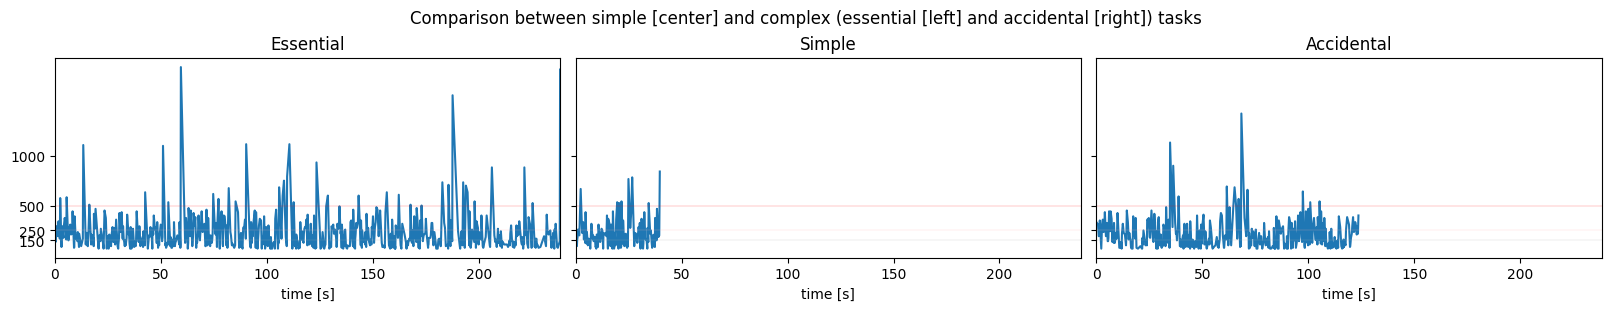

In [13]:
### DEMO: Plot data
# => [pup]Data_[simple/ess]

wTime = 10 # [s]
wPace = 'retrograde'

### 1. Apply metrics
# => 1: simple
# => 2: complex
## 1.1 nbFixOverDuration 250
# df1 = fixData_simple['Fixation Duration'].copy(deep=True)
# df2 = fixData_ess['Fixation Duration'].copy(deep=True)
df1 = fixData_simple.copy(deep=True)
npf1, npft1, _ = adaptToSlidingWindow(df1, 'Fixation Duration', wTime , wPace)
w1 = wTime * 1000
l1 = len(npf1)

# For 2 and 3...
df2 = fixData_ess.copy(deep=True)
df3 = fixData_acc.copy(deep=True)
npf2, npft2, _ = adaptToSlidingWindow(df2, 'Fixation Duration', wTime , wPace)
npf3, npft3, _ = adaptToSlidingWindow(df3, 'Fixation Duration', wTime , wPace)
w2 = wTime * 1000
l2 = len(npf2)
w3 = wTime * 1000
l3 = len(npf3)

## 1.3 nbFixOverDuration (greater than 250 and 500 ms)
cnt250_res1 = np.empty(l1)
cnt500_res1 = np.empty(l1)
for i in range(l1):
    iStart = i
    iEnd = sum((npft1 - npft1[iStart] - wTime*1000) < 0)
    longFix1 = npf1[iStart:iEnd]
    # longFix1 = df1[i:i+(w1-1)]

    (cnt250_res1[i], mStats250_1, _) = \
        metric__nbFixOverDuration(longFix1, params={'thrdFixDuration':250})
    (cnt500_res1[i], mStats500_1, _) = \
        metric__nbFixOverDuration(longFix1, params={'thrdFixDuration':500})

#cnt250_res = norm(cnt250_res)

cnt250_res2 = np.empty(l2)
cnt500_res2 = np.empty(l2)
for i in range(l2):
    iStart = i
    iEnd = sum((npft2 - npft2[iStart] - wTime*1000) < 0)
    longFix2 = npf2[iStart:iEnd]
    # longFix2 = df2[i:i+(w2-1)]
    (cnt250_res2[i], mStats250_2, _) = \
        metric__nbFixOverDuration(longFix2, params={'thrdFixDuration':250})
    (cnt500_res2[i], mStats500_2, _) = \
        metric__nbFixOverDuration(longFix2, params={'thrdFixDuration':500})
cnt250_res3 = np.empty(l3)
cnt500_res3 = np.empty(l3)
for i in range(l3):
    iStart = i
    iEnd = sum((npft3 - npft3[iStart] - wTime*1000) < 0)
    longFix3 = npf3[iStart:iEnd]
    # longFix3 = df3[i:i+(w3-1)]
    (cnt250_res3[i], mStats250_3, _) = \
        metric__nbFixOverDuration(longFix3, params={'thrdFixDuration':250})
    (cnt500_res3[i], mStats500_3, _) = \
        metric__nbFixOverDuration(longFix3, params={'thrdFixDuration':500})



## 1.4 Plot results
fig, (ax11, ax12, ax21) = plt.subplots(1, 3, figsize=(16, 3), sharey=True, layout="constrained")
fig.suptitle('Comparison between simple [center] and complex (essential [left] and accidental [right]) tasks')


xlim = [0, max(npft1[-1], npft2[-1], npft3[-1])/1000]
mmCnt500_res1 = modmax(cnt500_res1)
plotFixDuration(ax12, npft1, npf1,
    params={
        'title': 'Simple', 'ylabel': 'fixation duration [ms]', 'xlabel': 'time [s]', 'xlim': xlim #,
        #'cnt': {'250': cnt250_res1, '500': cnt500_res1, 'mm500': mmCnt500_res1}
    })
mmCnt500_res2 = modmax(cnt500_res2)
plotFixDuration(ax11, npft2, npf2, 
    params={
        'title': 'Essential', 'xlabel': 'time [s]', 'xlim': xlim #,
        #'cnt': {'250': cnt250_res2, '500': cnt500_res2, 'mm500': mmCnt500_res2}
    })
mmCnt500_res3 = modmax(cnt500_res3)
plotFixDuration(ax21, npft3, npf3,
    params={
        'title': 'Accidental', 'ylabel': 'fixation duration [ms]', 'xlabel': 'time [s]', 'xlim': xlim #,
        #'ylabel2': '# fixations', 
        #'cnt': {'250': cnt250_res3, '500': cnt500_res3, 'mm500': mmCnt500_res3}
    })
# ax11.plot(dft1/1000, cnt250_res1)
# ax11.plot(dft1/1000, cnt500_res1, 'tab:orange')

# mmCnt500_res1 = modmax(cnt500_res1)
# for pos in range(l1):
#     localMax = mmCnt500_res1[pos]
#     if localMax > 0:
#         ax11.axvline(dft1[pos]/1000, linewidth=0.3, color=(0, 0, 0, 0.5))

# ax12.plot(dft2/1000, cnt250_res2)
# ax12.plot(dft2/1000, cnt500_res2, 'tab:orange')
# ax21.plot(dft3/1000, cnt250_res3)
# ax21.plot(dft3/1000, cnt500_res3, 'tab:orange')
# mmCnt500_res2 = modmax(cnt500_res2)
# for pos in range(l2):
#     localMax = mmCnt500_res2[pos]
#     if localMax > 0:
#         ax12.axvline(dft2[pos]/1000, linewidth=0.3, color=(0, 0, 0, 0.5))
# mmCnt500_res3 = modmax(cnt500_res3)
# for pos in range(l3):
#     localMax = mmCnt500_res3[pos]
#     if localMax > 0:
#         ax21.axvline(dft2[pos]/1000, linewidth=0.3, color=(0, 0, 0, 0.5))

for ax in fig.get_axes():
    ax.label_outer()


## 1.5 Temporal Areas of Interes: tAoIs
# Each vertical corresponds to the end of a time window of size w1/w2
# 
tAOIs1 = -np.ones((l1, 2))
for pos in range(l1):
    localMax = mmCnt500_res1[pos]
    if localMax > 0:
        twEnd = npft1[pos]
        twStart = npft1[sum(npft1 < (twEnd - (wTime*1000)))]
        # twStart = twEnd - (wTime*1000)

        tAOIs1[pos] = [twStart, twEnd]

tAOIs2 = -np.ones((l2, 2))
for pos in range(l2):
    localMax = mmCnt500_res2[pos]
    if localMax > 0:
        twEnd = npft2[pos]
        twStart = npft2[sum(npft2 < (twEnd - (wTime*1000)))]
        # twStart = twEnd - (wTime*1000)
        tAOIs2[pos] = [twStart, twEnd]
tAOIs3 = -np.ones((l3, 2))
for pos in range(l3):
    localMax = mmCnt500_res3[pos]
    if localMax > 0:
        twEnd = npft3[pos]
        twStart = npft3[sum(npft3 < (twEnd - (wTime*1000)))]
        # twStart = twEnd - (wTime*1000)
        tAOIs3[pos] = [twStart, twEnd]


# 1.6 Linked model elements 
dp1 = pupData_simple.copy(deep=True)
dp2 = pupData_ess.copy(deep=True)
dp3 = pupData_acc.copy(deep=True)
# 1.6.1. Create a dictionnaries of model elements
def set_element_nona(df, naLabel = 'unk', elmtColName = 'element', nonaSuffix = '_nona'):
    # Add the 'element' column in df
    nonaColName = elmtColName + nonaSuffix
    df[nonaColName] = df[elmtColName]
    # Replace NA entries by a given label
    df.loc[df[nonaColName].isna(), [nonaColName]] = naLabel

    # Create a dictionary of elements, where elements with naLabel are in first position
    # with the associated value -1
    model_elements = df[nonaColName].unique()
    model_elements = np.insert(np.delete(model_elements, model_elements=='unk'), 0, naLabel)
    model_elements = {model_elements[i]:i for i in range(len(model_elements))}
    model_elements[naLabel] = -1

    return model_elements

model_elements1 = set_element_nona(dp1)
model_elements2 = set_element_nona(dp2)
model_elements3 = set_element_nona(dp3)

# 1.6.2 Retrieve the associated elements from pupData
linkedElmt1 = []
t0 = dp1['dt'].iloc[0]
for pos in range(l1):
    if tAOIs1[pos][0] > 0:
        tStart = t0 + tAOIs1[pos][0]
        tEnd = t0 + tAOIs1[pos][1]
        linkedPupData = dp1.loc[
            (tStart <= dp1['dt']) & (dp1['dt'] <= tEnd),
            ['dt', 'element', 'element_nona']
        ]

        linkedElmt1.append(linkedPupData)

linkedElmt2 = []
t0 = dp2['dt'].iloc[0]
for pos in range(l2):
    if tAOIs2[pos][0] > 0:
        tStart = t0 + tAOIs2[pos][0]
        tEnd = t0 + tAOIs2[pos][1]
        linkedPupData = dp2.loc[
            (tStart <= dp2['dt']) & (dp2['dt'] <= tEnd),
            ['dt', 'element', 'element_nona']
        ]

        linkedElmt2.append(linkedPupData)
linkedElmt3 = []
t0 = dp3['dt'].iloc[0]
for pos in range(l3):
    if tAOIs3[pos][0] > 0:
        tStart = t0 + tAOIs3[pos][0]
        tEnd = t0 + tAOIs3[pos][1]
        linkedPupData = dp3.loc[
            (tStart <= dp3['dt']) & (dp3['dt'] <= tEnd),
            ['dt', 'element', 'element_nona']
        ]

        linkedElmt3.append(linkedPupData)

display(linkedElmt1)

'Column 1:'

'Activity_1ru2k09, t1:8.249086000000126'

'Activity_01dwq74, t2:14.798402999999933'

'dt_disc:14.798402999999933, dt_pdisc:24.92225399999972'

'Column 2:'

'Activity_0awd1v7, t1:64.06803700000002'

'Activity_07sfu70, t2:48.7946120000002'

'dt_disc:48.7946120000002, dt_pdisc:189.6208790000002'

'Column 3:'

'Activity_13c1b7j, t1:14.148382000000217'

'Activity_1ru2k09, t2:20.597689000000244'

'dt_disc:20.597689000000244, dt_pdisc:103.04712699999939'

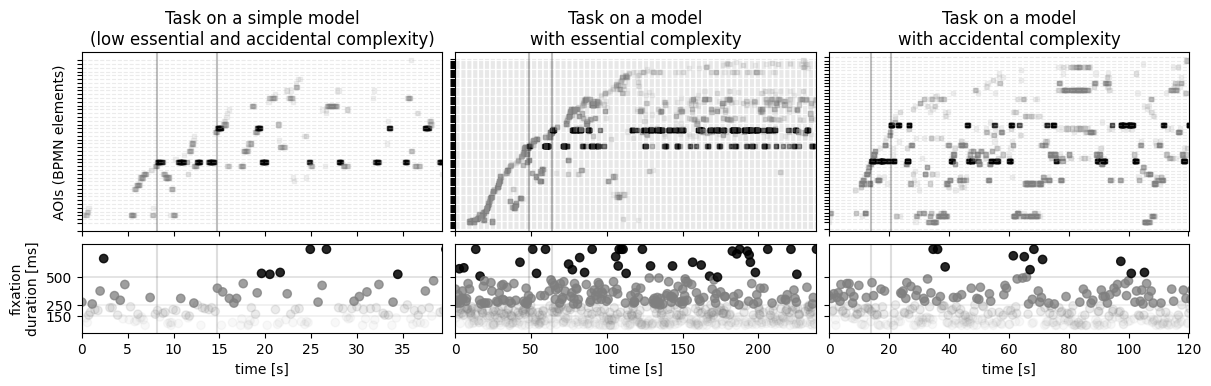

In [14]:
### DEMO: Scatter AoIs over time with Fixation duration

ds1 = npft1/1000
ds2 = npft2/1000
ds3 = npft3/1000
max_x_axis = [max(ds1), max(ds2), max(ds3)]

sec = lambda ms: ms/1000
dt = lambda t1, t2: t2-t1

def filter_elements(df, model_elements, params={}):
    # Remove elements not in EMI_SELECTED_OBJ_ID_PATTERNS
    obj_patterns = EMI_SELECTED_OBJ_ID_PATTERNS
    if 'obj_patterns' in params: obj_patterns = params['obj_patterns']
    dElmt = np.array([model_elements[k] for k in df['element_nona']])
    filtered_out = [
        any(list(map(lambda x: e.find(x) > -1, obj_patterns)))
        for e in df['element_nona']
    ]
    #dElmt = dElmt[filtered_out]
    #dsElmt = ds[filtered_out]

    return dElmt, filtered_out

def find_qElmt(df, qData):
    # Find first fix on the elements of the question
    qElements = (qData['element1'].iloc[0], qData['element2'].iloc[0])
    df['qElement'] = 0
    df.loc[df['element']==qElements[0], ['qElement']] = 1
    df.loc[df['element']==qElements[1], ['qElement']] = 2

    # Get the first occurence of fixation on a element (if exists!)
    d_qElements_firstFix = []
    if any(df.qElement == 1): d_qElements_firstFix.append(df[df.qElement == 1].iloc[0])
    else: d_qElements_firstFix.append(None)
    if any(df.qElement == 2): d_qElements_firstFix.append(df[df.qElement == 2].iloc[0])
    else: d_qElements_firstFix.append(None)

    return qElements, d_qElements_firstFix


# Plot
# fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(20,6), layout='constrained') #sharex=True, 
#px = 1/plt.rcParams['figure.dpi']
#cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(12, 3.75), layout='constrained') #sharex=True, 
fig_spec = fig.add_gridspec(3, 3)
#fig.suptitle('Comparison between simple and complex (essential & accidental) tasks')

###############################################################################
# AX11, AX21
ax11 = fig.add_subplot(fig_spec[0:-1, 0])
ax21 = fig.add_subplot(fig_spec[-1, 0])

dp1['dElmt'], bElmt_filter = filter_elements(dp1, model_elements1, params={
    'obj_patterns': EMI_ACTIVITY_OBJ_ID_PATTERNS
})

dElmt_filtred = dp1.loc[bElmt_filter, 'dElmt'].values
t = dp1.loc[bElmt_filter, 'dt'].values/1000
dp1.loc[bElmt_filter, 'dElmt_color'] = 'tab:gray'
dp1.loc[bElmt_filter, 'dElmt_alpha'] = .10
dp1.loc[bElmt_filter, 'dElmt_area'] = 3**2

# Change the color of activities involved in the question
qElements, d_qElements_firstFix = find_qElmt(pupData_simple, qData_simple)
dp1.loc[dp1['element_nona'] == qElements[0], 'dElmt_color'] = 'k'
dp1.loc[dp1['element_nona'] == qElements[0], 'dElmt_alpha'] = .25
dp1.loc[dp1['element_nona'] == qElements[0], 'dElmt_area'] = 3**2
dp1.loc[dp1['element_nona'] == qElements[1], 'dElmt_color'] = 'k'
dp1.loc[dp1['element_nona'] == qElements[1], 'dElmt_alpha'] = .25
dp1.loc[dp1['element_nona'] == qElements[1], 'dElmt_area'] = 3**2

x_axis1 = list(t)
y_axis1 = list(dElmt_filtred)

ax11.scatter(x_axis1, y_axis1,
             c=list(dp1.loc[bElmt_filter, 'dElmt_color']), 
             alpha=list(dp1.loc[bElmt_filter, 'dElmt_alpha']),
             marker="s", s=list(dp1.loc[bElmt_filter, 'dElmt_area']))

y_tickslabels = ['' for k in model_elements1.keys()] # ticks but no label
# y_tickslabels = ['' if not(k in qElements) else k for k in model_elements1.keys()]
#ax11.axhline(model_elements1[qElements[0]], color='tab:orange', alpha=0.25)
#ax11.axhline(model_elements1[qElements[1]], color='tab:purple', alpha=0.25)
ax11.set_yticks(list(model_elements1.values()), labels=y_tickslabels)
#ax11.set_yticklabels(y_tickslabels)

ax11.set_title(f'Task on a simple model\n(low essential and accidental complexity)')
ax11.set_xlabel('time [s]')
ax11.set_ylabel('AOIs (BPMN elements)')
ax11.grid(axis='y', which='major', linestyle='dashed', alpha=0.25)

ax11.axvline(sec(d_qElements_firstFix[0]['dt']), color='k', alpha=0.25)
ax11.axvline(sec(d_qElements_firstFix[1]['dt']), color='k', alpha=0.25)
ax21.axvline(sec(d_qElements_firstFix[0]['dt']), color='tab:gray', alpha=0.25)
ax21.axvline(sec(d_qElements_firstFix[1]['dt']), color='tab:gray', alpha=0.25)

ax11.set_xlim(0, t[-1])
ax21.set_xlim(0, t[-1])

# Display infos
display('Column 1:')
_t = sec(d_qElements_firstFix[1]['dt'])
display(f"{qElements[0]}, t1:{sec(d_qElements_firstFix[0]['dt'])}")
display(f"{qElements[1]}, t2:{_t}")
display(f"dt_disc:{_t}, dt_pdisc:{dt(_t, max_x_axis[0])}")

###############################################################################
# AX12, AX22
ax12 = fig.add_subplot(fig_spec[0:-1, 1])
ax22 = fig.add_subplot(fig_spec[-1, 1])

dp2['dElmt'], bElmt_filter = filter_elements(dp2, model_elements2, params={
    'obj_patterns': EMI_ACTIVITY_OBJ_ID_PATTERNS
})

dElmt_filtred = dp2.loc[bElmt_filter, 'dElmt'].values
t = dp2.loc[bElmt_filter, 'dt'].values/1000
dp2.loc[bElmt_filter, 'dElmt_color'] = 'tab:gray'
dp2.loc[bElmt_filter, 'dElmt_alpha'] = .10
dp2.loc[bElmt_filter, 'dElmt_area'] = 3**2

# Change the color of activities involved in the question
qElements, d_qElements_firstFix = find_qElmt(pupData_ess, qData_ess)
dp2.loc[dp2['element_nona'] == qElements[0], 'dElmt_color'] = 'k'
dp2.loc[dp2['element_nona'] == qElements[0], 'dElmt_alpha'] = .25
dp2.loc[dp2['element_nona'] == qElements[0], 'dElmt_area'] = 3**2
dp2.loc[dp2['element_nona'] == qElements[1], 'dElmt_color'] = 'k'
dp2.loc[dp2['element_nona'] == qElements[1], 'dElmt_alpha'] = .25
dp2.loc[dp2['element_nona'] == qElements[1], 'dElmt_area'] = 3**2

x_axis2 = list(t)
y_axis2 = list(dElmt_filtred)

ax12.scatter(x_axis2, y_axis2,
             c=list(dp2.loc[bElmt_filter, 'dElmt_color']), 
             alpha=list(dp2.loc[bElmt_filter, 'dElmt_alpha']),
             marker="s", s=list(dp2.loc[bElmt_filter, 'dElmt_area']))


y_tickslabels = ['' for k in model_elements2.keys()] # ticks but no label
# y_tickslabels = ['' if not(k in qElements) else k for k in model_elements2.keys()]
#ax12.axhline(model_elements2[qElements[0]], color='tab:orange', alpha=0.25)
#ax12.axhline(model_elements2[qElements[1]], color='tab:purple', alpha=0.25)
ax12.set_yticks(list(model_elements2.values()), labels=y_tickslabels)
# ax12.set_yticklabels(y_tickslabels)

ax12.set_title(f'Task on a model\nwith essential complexity')
ax12.set_xlabel('time [s]')
ax12.set_ylabel('AOIs (BPMN elements)')
ax12.grid(axis='y', which='major', linestyle='dashed', alpha=0.25)

ax12.axvline(sec(d_qElements_firstFix[0]['dt']), color='k', alpha=0.25)
ax12.axvline(sec(d_qElements_firstFix[1]['dt']), color='k', alpha=0.25)
ax22.axvline(sec(d_qElements_firstFix[0]['dt']), color='tab:gray', alpha=0.25)
ax22.axvline(sec(d_qElements_firstFix[1]['dt']), color='tab:gray', alpha=0.25)

ax12.set_xlim(0, t[-1])
ax22.set_xlim(0, t[-1])

# Display infos
display('Column 2:')
_t = sec(d_qElements_firstFix[1]['dt'])
display(f"{qElements[0]}, t1:{sec(d_qElements_firstFix[0]['dt'])}")
display(f"{qElements[1]}, t2:{_t}")
display(f"dt_disc:{_t}, dt_pdisc:{dt(_t, max_x_axis[1])}")

###############################################################################
# AX13, AX23
ax13 = fig.add_subplot(fig_spec[0:-1, 2])
ax23 = fig.add_subplot(fig_spec[-1, 2])

dp3['dElmt'], bElmt_filter = filter_elements(dp3, model_elements3, params={
    'obj_patterns': EMI_ACTIVITY_OBJ_ID_PATTERNS
})

dElmt_filtred = dp3.loc[bElmt_filter, 'dElmt'].values
t = dp3.loc[bElmt_filter, 'dt'].values/1000
dp3.loc[bElmt_filter, 'dElmt_color'] = 'tab:gray'
dp3.loc[bElmt_filter, 'dElmt_alpha'] = .10
dp3.loc[bElmt_filter, 'dElmt_area'] = 3**2

# Change the color of activities involved in the question
qElements, d_qElements_firstFix = find_qElmt(pupData_acc, qData_acc)
dp3.loc[dp3['element_nona'] == qElements[0], 'dElmt_color'] = 'k'
dp3.loc[dp3['element_nona'] == qElements[0], 'dElmt_alpha'] = .25
dp3.loc[dp3['element_nona'] == qElements[0], 'dElmt_area'] = 3**2
dp3.loc[dp3['element_nona'] == qElements[1], 'dElmt_color'] = 'k'
dp3.loc[dp3['element_nona'] == qElements[1], 'dElmt_alpha'] = .25
dp3.loc[dp3['element_nona'] == qElements[1], 'dElmt_area'] = 3**2

x_axis3 = list(t)
y_axis3 = list(dElmt_filtred)

ax13.scatter(x_axis3, y_axis3,
             c=list(dp3.loc[bElmt_filter, 'dElmt_color']), 
             alpha=list(dp3.loc[bElmt_filter, 'dElmt_alpha']),
             marker="s", s=list(dp3.loc[bElmt_filter, 'dElmt_area']))



y_tickslabels = ['' for k in model_elements3.keys()] # ticks but no label
# y_tickslabels = ['' if not(k in qElements) else k for k in model_elements3.keys()]
#ax13.axhline(model_elements3[qElements[0]], color='tab:orange', alpha=0.25)
#ax13.axhline(model_elements3[qElements[1]], color='tab:purple', alpha=0.25)
ax13.set_yticks(list(model_elements3.values()), labels=y_tickslabels)
# ax13.set_yticklabels(y_tickslabels)

ax13.set_title(f'Task on a model\nwith accidental complexity')
ax13.set_xlabel('time [s]')
ax13.set_ylabel('AOIs (BPMN elements)')
ax13.grid(axis='y', which='major', linestyle='dashed', alpha=0.25)

ax13.axvline(sec(d_qElements_firstFix[0]['dt']), color='k', alpha=0.25)
ax13.axvline(sec(d_qElements_firstFix[1]['dt']), color='k', alpha=0.25)
ax23.axvline(sec(d_qElements_firstFix[0]['dt']), color='tab:gray', alpha=0.25)
ax23.axvline(sec(d_qElements_firstFix[1]['dt']), color='tab:gray', alpha=0.25)

ax13.set_xlim(0, t[-1])
ax23.set_xlim(0, t[-1])

# Display infos
display('Column 3:')
_t = sec(d_qElements_firstFix[1]['dt'])
display(f"{qElements[0]}, t1:{sec(d_qElements_firstFix[0]['dt'])}")
display(f"{qElements[1]}, t2:{_t}")
display(f"dt_disc:{_t}, dt_pdisc:{dt(_t, max_x_axis[2])}")

###############################################################################
# Scatters: AX21, AX22, AX23
scatFixDuration(ax21, df1,
    params={
        'ylabel': 'fixation\nduration [ms]', 'xlabel': 'time [s]',
        #'cnt': {'250': cnt250_res1, '500': cnt500_res1, 'mm500': mmCnt500_res1}
        'bColor': False
    })
scatFixDuration(ax22, df2,
    params={
        'xlabel': 'time [s]',
        #'cnt': {'250': cnt250_res1, '500': cnt500_res1, 'mm500': mmCnt500_res1}
        'bColor': False
    })
scatFixDuration(ax23, df3,
    params={
        'xlabel': 'time [s]',
        #'cnt': {'250': cnt250_res1, '500': cnt500_res1, 'mm500': mmCnt500_res1}
        'bColor': False
    })




# Adapt scales
def maximax(l):
    if type(l) is list: return max(list(map(maximax, l)))
    return l
x_scale = [0, max(max_x_axis)]
y_scale2 = [0, maximax([list(npf1), list(npf2), list(npf3)])]

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(x_scale[0], x_scale[1])

# ax21.set_ylim(-(1+.015)*y_scale2[0], (1+.015)*y_scale2[1])
# ax22.set_ylim(-(1+.015)*y_scale2[0], (1+.015)*y_scale2[1])
# ax23.set_ylim(-(1+.015)*y_scale2[0], (1+.015)*y_scale2[1])
#ax22.set_yticks(list(model_elements.values()))
#ax22.set_yticklabels()

plt.savefig(IMG_DIR + \
            rf"\fine-grained_analysis_AoIs_over_time.{sample_pID}T{sample_tID['Simple']}_{sample_tID['Ess']}_{sample_tID['Acc']}.pdf")
plt.savefig(IMG_DIR + \
            rf"\fine-grained_analysis_AoIs_over_time.{sample_pID}T{sample_tID['Simple']}_{sample_tID['Ess']}_{sample_tID['Acc']}.png")
plt.show()


## Exploring the participants' visual behaviors

Inductive analysis (at fined-grained level) in the time perspective only. The analysis focuses on the temporal evolution of users’ visual behavior during process model comprehension tasks on models with varying (types and level of) complexity.

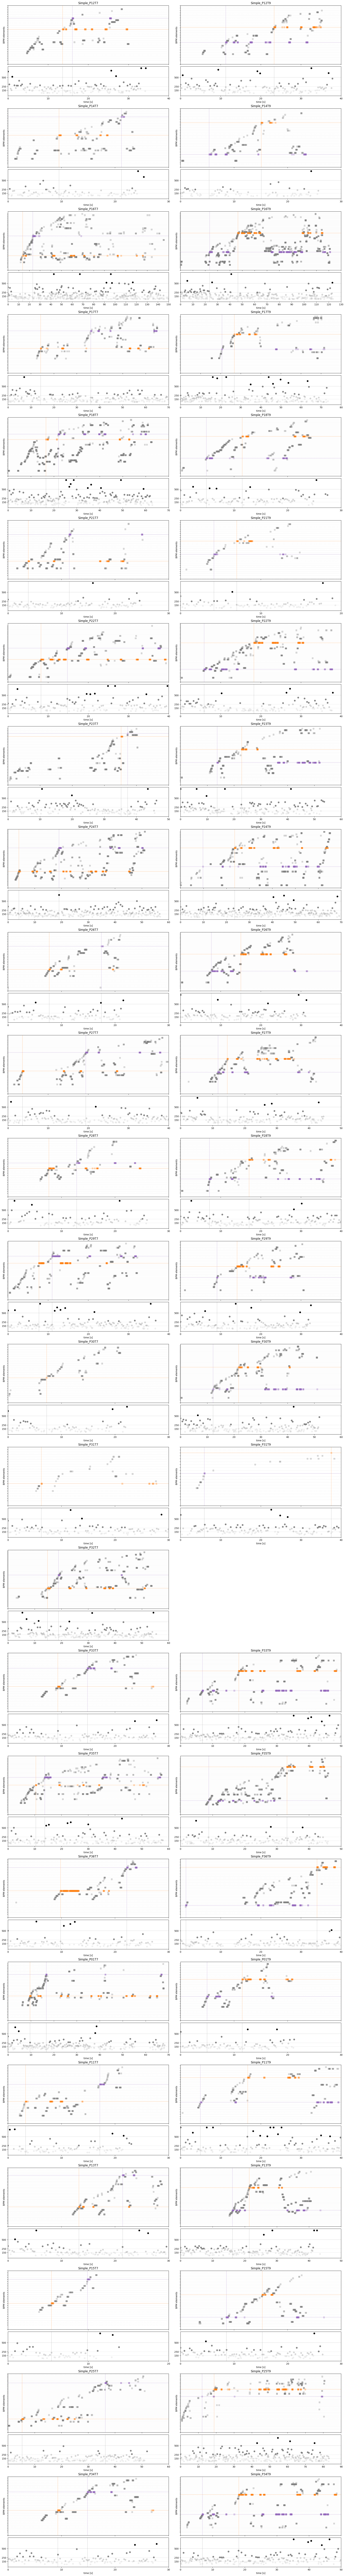

In [ ]:
# Create scatters by type & level of complexity: AoIs vs time + Fixation duration

# For all part and all task
Tasks = {
    'ess': [3, 5],
    'simple': [7, 9], 
    'acc': [19, 21]
}

TasksToPlot = Tasks['simple']

# -> Already defined
# def set_dt(df, tsCol = 'Timestamp', dtCol = 'dt')
# def set_element_nona(df, naLabel = 'unk', elmtColName = 'element', nonaSuffix = '_nona'):
# def filter_elements(df, model_elements):
# def find_qElmt(df, qData):

# Data
# df1 = fixData_simple.copy(deep=True)
# df2 = fixData_ess.copy(deep=True)
# df3 = fixData_acc.copy(deep=True)
#
# dp1 = pupData_simple.copy(deep=True)
# dp2 = pupData_ess.copy(deep=True)
# dp3 = pupData_acc.copy(deep=True)
#
# model_elements1 = set_element_nona(dp1)
# model_elements2 = set_element_nona(dp2)
# model_elements3 = set_element_nona(dp3)

def scatterModel(axp, axf, dp, df, qData, model_elements, params={}):

    dp['dElmt'], bElmt_filter = filter_elements(dp, model_elements)

    dElmt_filtred = dp.loc[bElmt_filter, 'dElmt'].values
    t = dp.loc[bElmt_filter, 'dt'].values/1000
    dp.loc[bElmt_filter, 'dElmt_color'] = 'tab:gray'

    # Change the color of activities involved in the question
    qElements, d_qElements_firstFix = find_qElmt(dp, qData)
    if qElements[0]: dp.loc[dp['element_nona'] == qElements[0], 'dElmt_color'] = 'tab:orange'
    if qElements[1]: dp.loc[dp['element_nona'] == qElements[1], 'dElmt_color'] = 'tab:purple'

    x_axis1 = list(t)
    y_axis1 = list(dElmt_filtred)

    axp.scatter(x_axis1, y_axis1, c=list(dp.loc[bElmt_filter, 'dElmt_color']), 
                marker="s", alpha=0.15)

    tBins = list(make_ticks(0, t[-1], 10, maxSteps=20))
    x_tickslabels = ['' for k in tBins] # ticks but no label
    axp.set_xticks(tBins, labels=x_tickslabels)

    y_tickslabels = ['' for k in model_elements.keys()] # ticks but no label
    # y_tickslabels = ['' if not(k in qElements) else k for k in model_elements.keys()]
    if qElements[0] and (qElements[0] in model_elements.keys()):
        axp.axhline(model_elements[qElements[0]], color='tab:orange', alpha=0.25)
    if qElements[1] and (qElements[1] in model_elements.keys()):
        axp.axhline(model_elements[qElements[1]], color='tab:purple', alpha=0.25)
    axp.set_yticks(list(model_elements.values()), labels=y_tickslabels)
    #axp.set_yticklabels(y_tickslabels)

    if 'title' in params.keys(): axp.set_title(params['title'])
    if 'xlabel' in params.keys(): axp.set_xlabel(params['xlabel'])
    axp.set_ylabel('BPM elements')
    if 'ylabel' in params.keys(): axp.set_ylabel(params['ylabel'])

    axp.grid(axis='y', which='major', linestyle='dashed', alpha=0.25)

    if len(d_qElements_firstFix) > 0:
        axp.axvline((d_qElements_firstFix[0]['dt'])/1000, color='tab:orange', alpha=0.25)
    if len(d_qElements_firstFix) > 1:
        if(not(d_qElements_firstFix[1] is None)):
            axp.axvline((d_qElements_firstFix[1]['dt'])/1000, color='tab:purple', alpha=0.25)

    axp.set_xlim(0, tBins[-1])

    ## Plot (scatter) fixation duration
    params_df = {'xlabel': 'time [s]'}
    if 'params_df' in params.keys(): params_df = params['params_df']
    scatFixDuration(axf, df, params=params_df)

    axf.set_xticks(tBins)
    if len(d_qElements_firstFix) > 0:
        axf.axvline((d_qElements_firstFix[0]['dt'])/1000, color='tab:gray', alpha=0.25)
    if len(d_qElements_firstFix) > 1:
        if(not(d_qElements_firstFix[1] is None)):
            axf.axvline((d_qElements_firstFix[1]['dt'])/1000, color='tab:gray', alpha=0.25)
    axf.set_xlim(0, tBins[-1])

###############################################################################


# PARTICIPANT_READING_STRATEGY1 = [
#     'P01', 
#     'P11', 'P14', 'P15', ('P19'),
#     ('P20'), 'P21', 'P22', 'P23', 'P28', 'P29', 
#     'P30', 'P31', 'P33'
# ]
# famParticipants = [
#     'P01', 
#     'P12', 'P13', 'P14', 
#     'P21', 'P23', 'P24', 'P26', 'P27', 'P28', 
#     'P30', 'P32', 'P34', 'P36'
# ]
# Constants already defined!
selectedPartIDs = participantIDs # ['P12', 'P27'] # participantIDs
nSelectedPartIDs = len(selectedPartIDs)

selectedTaskIDs = TasksToPlot
nSelectedTaskIDs = len(selectedTaskIDs)


# fig, ax = plt.subplots(nSelectedPartIDs*2, 2, figsize=(20, nSelectedPartIDs*10), layout='constrained') #, sharex=True
fig = plt.figure(figsize=(20, nSelectedPartIDs*6), layout='constrained')
fig_spec = fig.add_gridspec(nSelectedPartIDs*3, 2)

### For all participants
axL = 0
max_ts = -1
for pID in selectedPartIDs:

    # if axL > 0: continue

    dfFilters = pd.DataFrame(
        pupiFiltered_l[['Timestamp', 'Fixation Duration']].values, 
        columns=['ts', 'area']
    )
    labels = []

    ### For all tasks
    axC = 0
    for tID in selectedTaskIDs: #taskIDs:
        col = f'{pID}T{tID}'

        # Skip the loop if not define in Task.
        if tID in Tasks['ess']: label = f'Ess_{col}'
        elif tID in Tasks['simple']: label = f'Simple_{col}'
        elif tID in Tasks['acc']: label = f'Acc_{col}'
        else: continue
        labels.append(label)


        dpFilters = \
            (pupiFiltered_l['currentQuestion'] == tID).values & \
            (pupiFiltered_l['participant'] == pID).values
        # if no data, continue
        if not any(dpFilters): continue
        dp = pupiFiltered_l.loc[dpFilters].copy(deep=True)
        set_dt(dp)
        model_elements = set_element_nona(dp)


        dfFilters = \
            (fixationData['currentQuestion'] == tID).values & \
            (fixationData['participant'] == pID).values
        df = fixationData.loc[dfFilters].copy(deep=True)
        set_dt(df)

        qData = question_details[question_details['id'] == tID]

        # axp = ax[axL][axC]
        # axf = ax[axL+1][axC]
        axp = fig.add_subplot(fig_spec[axL:axL+2, axC])
        axf = fig.add_subplot(fig_spec[axL+2, axC])

        scatterModel(axp, axf, dp, df, qData, model_elements, {'title': label})

        axC += 1
    # FOR: tID

    axL += 3

# FOR: pID
    
# for ax in fig.get_axes():
#     ax.label_outer()

plt.show()

In [16]:
# Observation: simple task are shorter in (execution) time
# Execution time => performance.

# Use fixationData
# For all part and all task
Tasks = {
    'ess': [3, 5],
    'simple': [7, 9], 
    'acc': [19, 21]
}
ComparisonGroup = [[3, 7, 19], [5, 9, 21]]
# PARTICIPANT_READING_STRATEGY1 = [
#     'P01', 
#     'P11', 'P14', 'P15', ('P19'),
#     ('P20'), 'P21', 'P22', 'P23', 'P28', 'P29', 
#     'P30', 'P31', 'P33'
# ]
# famParticipants = [
#     'P01', 
#     'P12', 'P13', 'P14', 
#     'P21', 'P23', 'P24', 'P26', 'P27', 'P28', 
#     'P30', 'P32', 'P34', 'P36'
# ]
# Constants already defined!
selectedPartIDs = participantIDs # ['P12', 'P27'] # participantIDs
nSelectedPartIDs = len(selectedPartIDs)

selectedTaskIDs = [7, 9, 3, 5, 19, 21]
nSelectedTaskIDs = len(selectedTaskIDs)

### For all participants
measures = {'pID': [], 'tID': [], 'phase1': [], 'phase2': [], 'compGrp':[]}
for pID in selectedPartIDs:

    ### For all tasks
    axC = 0
    for tID in selectedTaskIDs: #taskIDs:
        dfFilters = \
            (fixationData['currentQuestion'] == tID).values & \
            (fixationData['participant'] == pID).values
        
        # /!\ 
        # Data for Simple tasks are duplicated to make comparisons
        # in the deductive analysis
        # /!\
        if tID in Tasks['simple']:
            dfFilters &= (fixationData['Type3'] == 'essentialComlexity').values

        compGrp = 0
        if tID in ComparisonGroup[0]:
            compGrp = 1
        elif tID in ComparisonGroup[1]:
            compGrp = 2
        else:
            raise ValueError(f'Unknown ComparisonGroup for task {tID}.')


        df = fixationData.loc[dfFilters].copy(deep=True)
        if not any(dfFilters): continue
        set_dt(df)
        model_elements = set_element_nona(df)

        qData = question_details[question_details['id'] == tID]

        qElements, d_qElements_firstFix = find_qElmt(dp, qData)

        # Seperate in disc./post-disc. phases
        # In df, the column 'Phase' contains 1 or 2 depnding on the phase.
        get_subparts(df, qElements)

        ts1 = df.loc[df['Phase']==1, 'Timestamp'].values
        ts2 = df.loc[df['Phase']==2, 'Timestamp'].values

        measures['pID'].append(pID)
        measures['tID'].append(tID)
        measures['phase1'].append(ts1[-1] - ts1[0])
        measures['phase2'].append(ts2[-1] - ts2[0])
        measures['compGrp'].append(compGrp)
        

measures = pd.DataFrame(measures)
print('Example for P22:')
display(measures.loc[measures['pID']=='P22', :])



# Calculate Wilcoxon test
res = {'Phase1_ess': {}, 'Phase2_ess': {}, 'Phase1_acc': {}, 'Phase2_acc': {}}
comp_measures_cols=['pID', 'tID_a', 'phase1_a', 'phase2_a', 'tID_b', 'phase1_b', 'phase2_b']


comp_measures = pd.DataFrame(columns=comp_measures_cols)
for _t1, _t2 in zip(Tasks['simple'], Tasks['ess']):
    s1 = measures.loc[measures['tID']==_t1, :]
    s2 = measures.loc[measures['tID']==_t2, :]
    s = s1.merge(s2, left_on=['pID'], right_on=['pID'], how='inner', suffixes=('_a', '_b'))

    comp_measures = pd.concat(
        [comp_measures, pd.DataFrame(s.loc[:, comp_measures_cols])],
        ignore_index=True)

res['Phase1_ess'] = my_wilcoxon(comp_measures['phase1_a'], comp_measures['phase1_b'])
res['Phase2_ess'] = my_wilcoxon(comp_measures['phase2_a'], comp_measures['phase2_b'])



comp_measures = pd.DataFrame(columns=comp_measures_cols)
for _t1, _t2 in zip(Tasks['simple'], Tasks['acc']):
    s = (measures.loc[measures['tID']==_t1, :]).merge(measures.loc[measures['tID']==_t2, :], 
                                                      left_on=['pID'], right_on=['pID'],
                                                      how='inner', suffixes=('_a', '_b'))

    comp_measures = pd.concat(
        [comp_measures, pd.DataFrame(s.loc[:, comp_measures_cols])], 
        ignore_index=True)

res['Phase1_acc'] = my_wilcoxon(comp_measures['phase1_a'], comp_measures['phase1_b'])
res['Phase2_acc'] = my_wilcoxon(comp_measures['phase2_a'], comp_measures['phase2_b'])



comp_measures = pd.DataFrame(columns=comp_measures_cols)
for _t1, _t2 in zip(Tasks['ess'], Tasks['acc']):
    s = (measures.loc[measures['tID']==_t1, :]).merge(measures.loc[measures['tID']==_t2, :], 
                                                      left_on=['pID'], right_on=['pID'],
                                                      how='inner', suffixes=('_a', '_b'))

    comp_measures = pd.concat(
        [comp_measures, pd.DataFrame(s.loc[:, comp_measures_cols])], 
        ignore_index=True)

res['Phase1_ess_acc'] = my_wilcoxon(comp_measures['phase1_a'], comp_measures['phase1_b'])
res['Phase2_ess_acc'] = my_wilcoxon(comp_measures['phase2_a'], comp_measures['phase2_b'])


print('Statistics:')
display(pd.DataFrame(res))

Example for P22:


pID  tID     phase1      phase2  compGrp
36  P22    7  14790.045   24488.972        1
37  P22    9  19356.225   17798.029        2
38  P22    3  79082.970  137176.686        1
39  P22    5  64084.702  173822.584        2
40  P22   19  20739.416  102155.491        1
41  P22   21  14956.690   65759.503        2

Statistics:


Phase1_ess    Phase2_ess    Phase1_acc    Phase2_acc  Phase1_ess_acc  \
stat  3.300000e+01  1.400000e+01    453.000000  2.000000e+00    3.600000e+01   
p     1.141487e-11  3.907985e-13      0.114304  1.065814e-14    8.842704e-12   
m1    1.896160e+04  2.550948e+04  18961.600204  2.550948e+04    5.364928e+04   
m2    5.412348e+04  9.089440e+04  21976.920286  8.074064e+04    2.180668e+04   

      Phase2_ess_acc  
stat      531.000000  
p           0.309051  
m1      90970.805580  
m2      81720.547880

In [17]:
# Observation: There are more fixations with longer duration in complex tasks (number of deep mental processing fixations)
# Fixation duration => Behavioral (psychological, related to mental processing)

# Use fixationData
# For all part and all task
Tasks = {
    'ess': [3, 5],
    'simple': [7, 9], 
    'acc': [19, 21]
}
# PARTICIPANT_READING_STRATEGY1 = [
#     'P01', 
#     'P11', 'P14', 'P15', ('P19'),
#     ('P20'), 'P21', 'P22', 'P23', 'P28', 'P29', 
#     'P30', 'P31', 'P33'
# ]
# famParticipants = [
#     'P01', 
#     'P12', 'P13', 'P14', 
#     'P21', 'P23', 'P24', 'P26', 'P27', 'P28', 
#     'P30', 'P32', 'P34', 'P36'
# ]
# Constants already defined!
selectedPartIDs = participantIDs # ['P12', 'P27'] # participantIDs
nSelectedPartIDs = len(selectedPartIDs)

selectedTaskIDs = [7, 9, 3, 5, 19, 21]
nSelectedTaskIDs = len(selectedTaskIDs)

### For all participants
measures = {'pID': [], 'tID': [], 'phase1': [], 'phase2': []}
for pID in selectedPartIDs:

    ### For all tasks
    axC = 0
    for tID in selectedTaskIDs: #taskIDs:
        dfFilters = \
            (fixationData['currentQuestion'] == tID).values & \
            (fixationData['participant'] == pID).values
        
        # /!\ 
        # Data for Simple tasks are duplicated to make comparisons
        # in the deductive analysis
        # /!\
        if tID in Tasks['simple']:
            dfFilters &= (fixationData['Type3'] == 'essentialComlexity').values

        df = fixationData.loc[dfFilters].copy(deep=True)
        if not any(dfFilters): continue
        set_dt(df)
        model_elements = set_element_nona(df)

        qData = question_details[question_details['id'] == tID]

        qElements, d_qElements_firstFix = find_qElmt(dp, qData)

        # Seperate in disc./post-disc. phases
        # In df, the column 'Phase' contains 1 or 2 depnding on the phase.
        get_subparts(df, qElements)

        measures['pID'].append(pID)
        measures['tID'].append(tID)
        measures['phase1'].append(
            df.loc[(df['Phase']==1).values & (df['Fixation Duration']>500).values, 'Phase'].count())
        measures['phase2'].append(
            df.loc[(df['Phase']==2).values & (df['Fixation Duration']>500).values, 'Phase'].count())


measures = pd.DataFrame(measures)
print('Example for P22:')
display(measures.loc[measures['pID']=='P22', :])



# Calculate Wilcoxon test
res = {'Phase1_ess': {}, 'Phase2_ess': {}, 'Phase1_acc': {}, 'Phase2_acc': {}}
comp_measures_cols=['pID', 'tID_a', 'phase1_a', 'phase2_a', 'tID_b', 'phase1_b', 'phase2_b']


comp_measures = pd.DataFrame(columns=comp_measures_cols)
for _t1, _t2 in zip(Tasks['simple'], Tasks['ess']):
    s1 = measures.loc[measures['tID']==_t1, :]
    s2 = measures.loc[measures['tID']==_t2, :]
    s = s1.merge(s2, left_on=['pID'], right_on=['pID'], how='inner', suffixes=('_a', '_b'))

    comp_measures = pd.concat(
        [comp_measures, pd.DataFrame(s.loc[:, comp_measures_cols])],
        ignore_index=True)

res['Phase1_ess'] = my_wilcoxon(comp_measures['phase1_a'], comp_measures['phase1_b'])
res['Phase2_ess'] = my_wilcoxon(comp_measures['phase2_a'], comp_measures['phase2_b'])



comp_measures = pd.DataFrame(columns=comp_measures_cols)
for _t1, _t2 in zip(Tasks['simple'], Tasks['acc']):
    s = (measures.loc[measures['tID']==_t1, :]).merge(measures.loc[measures['tID']==_t2, :], 
                                                      left_on=['pID'], right_on=['pID'],
                                                      how='inner', suffixes=('_a', '_b'))

    comp_measures = pd.concat(
        [comp_measures, pd.DataFrame(s.loc[:, comp_measures_cols])], 
        ignore_index=True)

res['Phase1_acc'] = my_wilcoxon(comp_measures['phase1_a'], comp_measures['phase1_b'])
res['Phase2_acc'] = my_wilcoxon(comp_measures['phase2_a'], comp_measures['phase2_b'])



comp_measures = pd.DataFrame(columns=comp_measures_cols)
for _t1, _t2 in zip(Tasks['ess'], Tasks['acc']):
    s = (measures.loc[measures['tID']==_t1, :]).merge(measures.loc[measures['tID']==_t2, :], 
                                                      left_on=['pID'], right_on=['pID'],
                                                      how='inner', suffixes=('_a', '_b'))

    comp_measures = pd.concat(
        [comp_measures, pd.DataFrame(s.loc[:, comp_measures_cols])], 
        ignore_index=True)

res['Phase1_ess_acc'] = my_wilcoxon(comp_measures['phase1_a'], comp_measures['phase1_b'])
res['Phase2_ess_acc'] = my_wilcoxon(comp_measures['phase2_a'], comp_measures['phase2_b'])


print('Statistics: (number of deep mental processing fixations)')
display(pd.DataFrame(res))

Example for P22:


pID  tID  phase1  phase2
36  P22    7       1       7
37  P22    9       1       3
38  P22    3      10      15
39  P22    5       8      29
40  P22   19       0      11
41  P22   21       0      12

Statistics: (number of deep mental processing fixations)


C:\Users\TSorg\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\TSorg\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\TSorg\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Phase1_ess    Phase2_ess  Phase1_acc    Phase2_acc  Phase1_ess_acc  \
stat  142.000000  5.200000e+01  277.000000  2.850000e+01      210.000000   
p       0.000503  9.148756e-08    0.372613  1.382266e-08        0.011499   
m1      1.346939  2.816327e+00    1.346939  2.816327e+00        3.360000   
m2      3.428571  8.979592e+00    1.816327  9.755102e+00        1.840000   

      Phase2_ess_acc  
stat      524.500000  
p           0.675361  
m1          8.960000  
m2          9.800000

In [ ]:
# Observation: tasks with accidental complexity have more back and forth movements (higher revisit ratio)
# in the second phase than tasks with essential complexity
# Eye gaze movements => Behavioral.

# Use fixationData
# For all part and all task
Tasks = {
    'ess': [3, 5],
    'simple': [7, 9], 
    'acc': [19, 21]
}
# PARTICIPANT_READING_STRATEGY1['ParticipantID'] = [
#     'P01', 
#     'P11', 'P14', 'P15', ('P19'),
#     ('P20'), 'P21', 'P22', 'P23', 'P28', 'P29', 
#     'P30', 'P31', 'P33'
# ]
# famParticipants['ParticipantID'] = [
#     'P01', 
#     'P12', 'P13', 'P14', 
#     'P21', 'P23', 'P24', 'P26', 'P27', 'P28', 
#     'P30', 'P32', 'P34', 'P36'
# ]
# Constants already defined!
selectedPartIDs = participantIDs # ['P12', 'P27'] # participantIDs
nSelectedPartIDs = len(selectedPartIDs)

selectedTaskIDs = [7, 9, 3, 5, 19, 21]
nSelectedTaskIDs = len(selectedTaskIDs)

### For all participants
measures = {'pID': [], 'tID': [], 'phase1': [], 'phase2': []}
for pID in selectedPartIDs:

    ### For all tasks
    axC = 0
    for tID in selectedTaskIDs: #taskIDs:
        dfFilters = \
            (fixationData['currentQuestion'] == tID).values & \
            (fixationData['participant'] == pID).values
        
        # /!\ 
        # Data for Simple tasks are duplicated to make comparisons
        # in the deductive analysis
        # /!\
        if tID in Tasks['simple']:
            dfFilters &= (fixationData['Type3'] == 'essentialComlexity').values

        df = fixationData.loc[dfFilters].copy(deep=True)
        if not any(dfFilters): continue
        set_dt(df)
        model_elements = set_element_nona(df)
        dElmt, dElmt_filter = filter_elements(df, model_elements, params={
            'obj_patterns': EMI_ACTIVITY_OBJ_ID_PATTERNS
        })

        qData = question_details[question_details['id'] == tID]
        
        qElements, d_qElements_firstFix = find_qElmt(dp, qData)

        # Seperate in disc./post-disc. phases
        # In df, the column 'Phase' contains 1 or 2 depending on the phase.
        dictPhases = get_subparts(df, qElements)
        dPh1, dPh2 = dictPhases['search']['d'], dictPhases['solve']['d']

        temp_dPh = dPh1.copy(deep=True)
        # Remove consecutive fixation on same element
        for i in range(1, len(dPh1.index)):
            idx = dPh1.index[i]
            Xi, Xii = dPh1.iloc[i-1], dPh1.iloc[i]

            if Xii['element_nona'] == Xi['element_nona']: 
                temp_dPh.drop(idx, inplace=True)
        dPh1 = temp_dPh.copy(deep=True)

        temp_dPh = dPh2.copy(deep=True)
        for i in range(1, len(dPh2.index)):
            idx = dPh2.index[i]
            Xi, Xii = dPh2.iloc[i-1], dPh2.iloc[i]

            if Xii['element_nona'] == Xi['element_nona']:
                temp_dPh.drop(idx, inplace=True)
        dPh2 = temp_dPh.copy(deep=True)
        
        #    rho_revisit = n(revisits)/n(first_visits + revisits)
        # => rho_revisit = 1 - n(first_visits)/n(first_visits + revisits)
        # n(first_visits) = n(elements accessed once in the phase)
        # n(first_visits + revisits) = n(fixations in the phase)
        n1 = 1- len(dPh1['element_nona'].unique()) / len(dPh1.index)
        n2 = 1- len(dPh2['element_nona'].unique()) / len(dPh2.index)

        measures['pID'].append(pID)
        measures['tID'].append(tID)
        measures['phase1'].append(n1)
        measures['phase2'].append(n2)


measures = pd.DataFrame(measures)
print('Example for P22:')
display(measures.loc[measures['pID']=='P22', :])



## Calculate Wilcoxon test
# res_a: more revisits during post-discovery than discovery
res_a = {'Simple': {}, 'Esssential': {}, 'Accidental': {}}
comp_measures_cols=['pID', 'tID', 'phase1_a', 'phase2']

res_a['Simple'] = my_wilcoxon(
    measures.loc[measures['tID'].isin(Tasks['simple']), 'phase1'], 
    measures.loc[measures['tID'].isin(Tasks['simple']), 'phase2'])

res_a['Esssential'] = my_wilcoxon(
    measures.loc[measures['tID'].isin(Tasks['ess']), 'phase1'], 
    measures.loc[measures['tID'].isin(Tasks['ess']), 'phase2'])

res_a['Accidental'] = my_wilcoxon(
    measures.loc[measures['tID'].isin(Tasks['acc']), 'phase1'], 
    measures.loc[measures['tID'].isin(Tasks['acc']), 'phase2'])

# res_b: compare between different complexity levels and types
res_b = {'Phase1_ess': {}, 'Phase2_ess': {}, 'Phase1_acc': {}, 'Phase2_acc': {}}
comp_measures_cols=['pID', 'tID_a', 'phase1_a', 'phase2_a', 'tID_b', 'phase1_b', 'phase2_b']


comp_measures = pd.DataFrame(columns=comp_measures_cols)
for _t1, _t2 in zip(Tasks['simple'], Tasks['ess']):
    s1 = measures.loc[measures['tID']==_t1, :]
    s2 = measures.loc[measures['tID']==_t2, :]
    s = s1.merge(s2, left_on=['pID'], right_on=['pID'], how='inner', suffixes=('_a', '_b'))

    comp_measures = pd.concat(
        [comp_measures, pd.DataFrame(s.loc[:, comp_measures_cols])],
        ignore_index=True)

res_b['Phase1_ess'] = my_wilcoxon(comp_measures['phase1_a'], comp_measures['phase1_b'])
res_b['Phase2_ess'] = my_wilcoxon(comp_measures['phase2_a'], comp_measures['phase2_b'])



comp_measures = pd.DataFrame(columns=comp_measures_cols)
for _t1, _t2 in zip(Tasks['simple'], Tasks['acc']):
    s = (measures.loc[measures['tID']==_t1, :]).merge(measures.loc[measures['tID']==_t2, :], 
                                                      left_on=['pID'], right_on=['pID'],
                                                      how='inner', suffixes=('_a', '_b'))

    comp_measures = pd.concat(
        [comp_measures, pd.DataFrame(s.loc[:, comp_measures_cols])], 
        ignore_index=True)

res_b['Phase1_acc'] = my_wilcoxon(comp_measures['phase1_a'], comp_measures['phase1_b'])
res_b['Phase2_acc'] = my_wilcoxon(comp_measures['phase2_a'], comp_measures['phase2_b'])



comp_measures = pd.DataFrame(columns=comp_measures_cols)
for _t1, _t2 in zip(Tasks['ess'], Tasks['acc']):
    s = (measures.loc[measures['tID']==_t1, :]).merge(measures.loc[measures['tID']==_t2, :], 
                                                      left_on=['pID'], right_on=['pID'],
                                                      how='inner', suffixes=('_a', '_b'))

    comp_measures = pd.concat(
        [comp_measures, pd.DataFrame(s.loc[:, comp_measures_cols])], 
        ignore_index=True)

res_b['Phase1_ess_acc'] = my_wilcoxon(comp_measures['phase1_a'], comp_measures['phase1_b'])
res_b['Phase2_ess_acc'] = my_wilcoxon(comp_measures['phase2_a'], comp_measures['phase2_b'])


print('Statistics: (revisit ratio)')
print('Res A, compare revisit during phases:_')
display(pd.DataFrame(res_a))
print('Res B, compare revisit for diff. levels and tpyes of complexity:_')
display(pd.DataFrame(res_b))

Example for P22:


pID  tID    phase1    phase2
36  P22    7  0.551724  0.629630
37  P22    9  0.536585  0.595238
38  P22    3  0.618644  0.780105
39  P22    5  0.578431  0.870079
40  P22   19  0.500000  0.864486
41  P22   21  0.333333  0.759398

Statistics: (revisit ratio)
Res A, compare revisit during phases:_


Simple  Esssential    Accidental
stat  485.000000  165.000000  5.700000e+01
p       0.208462    0.000001  1.287166e-10
m1      0.543875    0.606496  5.849663e-01
m2      0.587128    0.714373  7.780155e-01

Res B, compare revisit for diff. levels and tpyes of complexity:_


Phase1_ess  Phase2_ess  Phase1_acc    Phase2_acc  Phase1_ess_acc  \
stat  396.000000  170.000000  466.000000  5.400000e+01      511.000000   
p       0.030793    0.000003    0.147543  1.814797e-10        0.226010   
m1      0.543875    0.587128    0.543875  5.871278e-01        0.606496   
m2      0.610257    0.713403    0.588741  7.761065e-01        0.584966   

      Phase2_ess_acc  
stat      223.000000  
p           0.000028  
m1          0.714373  
m2          0.778016